---

# Create network

In this notebook, I tried to create a network from the merged dataset (retrieved from GunViolenceArchive and MotherJones) 


Reference: [Catching that flight: Visualizing social network with Networkx and Basemap](https://towardsdatascience.com/catching-that-flight-visualizing-social-network-with-networkx-and-basemap-ce4a0d2eaea6)

---



In [1]:
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

#### install basemap

#### you should install these packages when running this notebook in Google Colab

!apt-get install libgeos-3.7.1

!apt-get install libgeos-dev

!pip install https://github.com/matplotlib/basemap/archive/master.zip

!pip install pyproj==1.9.6

### Before import basemap library, you should restart runtime

In [2]:
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [3]:
# import dataset
df = pd.read_csv("5merge.csv", index_col = False)
df.head()

,date,adr,p,n_killed,n_injured,city,state,LON,LAT,case,...,mental_health_details,weapons_obtained_legally,where_obtained,weapon_type,weapon_details,race,gender,mental_health_sources,sources_additional_age,type
0,2014-01-01,Rockingham Street and Berkley Avenue Extended ...,2.855649,2,2,Norfolk,Virginia,-76.278935,36.830788,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-03,Farmers Boulevard and 133rd Avenue Queens New ...,2.390389,1,3,Queens,New York,-73.762898,40.677500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-01-05,829 Parade St Erie Pennsylvania,2.390389,1,3,Erie,Pennsylvania,-80.074524,42.130038,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-01-11,3430 W. Capitol Street Jackson Mississippi,1.515717,0,4,Jackson,Mississippi,-90.228321,32.323689,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-01-12,University Drive Huntsville Alabama,1.620657,0,5,Huntsville,Alabama,-86.650390,34.736562,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#### I need to add index column to create network.
#### add index column (ind)
ind = []
for i in range(0, len(df), 1):
  num = i
  ind.append(num)

df['ind'] = ind

cols = list(df.columns.values)
cols.pop(cols.index('ind'))
df = df[['ind']+cols]

df.head()

df.to_csv("5merge.csv")

In [5]:
df = pd.read_csv("5merge.csv", index_col = 0, parse_dates = True)
df.set_index('ind')
df.head()

,ind,date,adr,p,n_killed,n_injured,city,state,LON,LAT,...,mental_health_details,weapons_obtained_legally,where_obtained,weapon_type,weapon_details,race,gender,mental_health_sources,sources_additional_age,type
0,0,2014-01-01,Rockingham Street and Berkley Avenue Extended ...,2.855649,2,2,Norfolk,Virginia,-76.278935,36.830789,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2014-01-03,Farmers Boulevard and 133rd Avenue Queens New ...,2.390389,1,3,Queens,New York,-73.762898,40.677500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2014-01-05,829 Parade St Erie Pennsylvania,2.390389,1,3,Erie,Pennsylvania,-80.074524,42.130038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2014-01-11,3430 W. Capitol Street Jackson Mississippi,1.515717,0,4,Jackson,Mississippi,-90.228321,32.323689,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2014-01-12,University Drive Huntsville Alabama,1.620657,0,5,Huntsville,Alabama,-86.650390,34.736562,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Why I created time-series graph?

This is solely because we need to indentify extraordinary event in the data.  
Also, by using time-series analysis, it allows us to test a contagion model. 


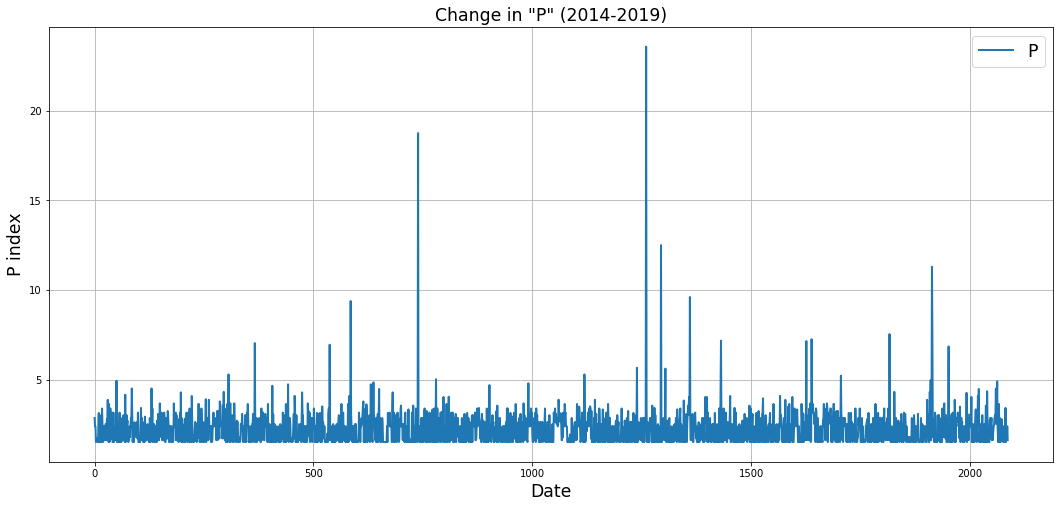

In [6]:
# plotting Parameter "P"
plt.rcParams["figure.figsize"] = (18,8)
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True
plt.rcParams['lines.linewidth'] = 2


plt.plot(df["p"], label = "P")

plt.xlabel("Date", fontsize = "xx-large")
plt.ylabel("P index", fontsize = "xx-large")
plt.title("Change in \"P\" (2014-2019)", fontsize = "xx-large")
plt.legend(fontsize = "xx-large", loc = "best")
plt.show()

---

One problem we face is there are events on a same day.  
Here are a list of the possible ideas to dealing with the problem.  

* (1) Summing up "p" on a daily basis.  
> * Problem: We will lose event-specific data.  
> * Gain: at least we can use time-series analysis techniques.
* (2) Create Network based on time stamps (as a node attribute).
> * Problem 1: we should find a different way to classify outstanding event.
> * Problem 2: we should find another method to model contagion or earthquake in a network we create.

---

Put specific problems aside, Let's start from constructing a network.  
To make a network, we need another index for each nodes, 
the size of node is the parameter "P" and the weight for each edges is also "P".  
The graph shuold be directed one on the US map. 

Here are two basic attributes required to construct a network from data:
  * Source: where a node start from
  * Target: where a node reach to 

source is all events, but how we define target?  

Basically we have time stamps, we can use this for target.
So, target is events after source event happened.

Here, we should consider that how a network looks like. What if we only construct a network only based on time-stamp, the network seems like a line except for some cases that events occured on a same day.

This is not a thing we want. We want to answer the question: how long an extraordinary event produce subsequent events.

In this manner, it is required to classify each event whether it is 'extraordinary'. A standard to discern extraordinary events from the others is based on 'P'. 




---

### Creating network

---


In [9]:
df.columns

Index(['ind', 'adr', 'p', 'n_killed', 'n_injured', 'state', 'LON', 'LAT',
       'case', 'summary', 'age_of_shooter', 'prior_signs_mental_health_issues',
       'mental_health_details', 'weapons_obtained_legally', 'where_obtained',
       'weapon_type', 'weapon_details', 'race', 'gender',
       'mental_health_sources', 'sources_additional_age', 'type'],
      dtype='object')

In [15]:
df['date'] = pd.to_datetime(df['date'])

In [16]:
G = nx.DiGraph()

In [ ]:
for i in range(0, len(df), 1):
  G.add_node(i, 
             date = df['date'][i],
             p = df['p'][i],
             n_killed = df['n_killed'][i],
             n_injured = df['n_injured'][i],
             LON = df['LON'][i],
             LAT = df['LAT'][i],)

In [ ]:
for i in G.nodes():
  for j in G.nodes():
    if G.nodes[i]['date'] < G.nodes[j]['date']:
      G.add_edge(i, j)
    else: 
      pass

In [ ]:
nx.write_gml(G, "graph.gml")

NetworkXError: ignored

---

To resolve the problem, I try to change the timestamps into new index.

if the result from comparing two element has same date, it assigns a same index value, and if not, they index number is increase (+1)

---

In [7]:
#### I need to add index column to create network.
#### add time index (ind_t)

df['ind_t'] = ""

In [8]:
df['ind_t'][0] = 0 
print(df['ind_t'][0])

0


/home/kh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
i = 0

for j in range(1, len(df), 1):
  if df['date'][j-1] < df['date'][j]:
    i += 1
    df['ind_t'][j] = i
    
  else:
    df['ind_t'][j] = i

/home/kh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/kh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [10]:
cols = list(df.columns.values)
cols.pop(cols.index('ind'))
cols.pop(cols.index('ind_t'))

df = df[['ind']+['ind_t']+cols]
df.head()

,ind,ind_t,date,adr,p,n_killed,n_injured,city,state,LON,...,mental_health_details,weapons_obtained_legally,where_obtained,weapon_type,weapon_details,race,gender,mental_health_sources,sources_additional_age,type
0,0,0,2014-01-01,Rockingham Street and Berkley Avenue Extended ...,2.855649,2,2,Norfolk,Virginia,-76.278935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2014-01-03,Farmers Boulevard and 133rd Avenue Queens New ...,2.390389,1,3,Queens,New York,-73.762898,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,2014-01-05,829 Parade St Erie Pennsylvania,2.390389,1,3,Erie,Pennsylvania,-80.074524,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,2014-01-11,3430 W. Capitol Street Jackson Mississippi,1.515717,0,4,Jackson,Mississippi,-90.228321,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,2014-01-12,University Drive Huntsville Alabama,1.620657,0,5,Huntsville,Alabama,-86.650390,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df.to_csv("6before-network.csv")

---

### Create a network again

---

In [ ]:
cols = list(df.columns.values)
print(cols)

['ind', 'ind_t', 'date', 'adr', 'p', 'n_killed', 'n_injured', 'state', 'LON', 'LAT', 'case', 'summary', 'age_of_shooter', 'prior_signs_mental_health_issues', 'mental_health_details', 'weapons_obtained_legally', 'where_obtained', 'weapon_type', 'weapon_details', 'race', 'gender', 'mental_health_sources', 'sources_additional_age', 'type']


In [ ]:
for n in range(0, len(df), 1):
  G.add_node(n,
             ind = df['ind'][n],
             ind_t = df['ind_t'][n], 
             date = df['date'][n],
             p = df['p'][n],
             n_killed = df['n_killed'][n],
             n_injured = df['n_injured'][n],
             LON = df['LON'][n],
             LAT = df['LAT'][n],)

In [ ]:
for i in G.nodes():
  for j in G.nodes():
    if G.nodes[i]['ind_t'] < G.nodes[j]['ind_t']:
      G.add_edge(i, j)
    else: 
      pass